In [1]:
## NB there are sometimes issues with xarray backend errors around reading netcdf4.
## Restarting kernel seems to fix these. 

import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import esmvalcore.preprocessor
import xarray as xr
import xesmf as xe
from tqdm import tqdm
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt
import dask
from nc_processing import calc_spatial_mean
from tqdm import tqdm
import scipy.stats as stats

def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    return ds

def read_in_ens_mean(dirs, ocean = False):
    """ returns (1) the ensemble mean dataset, and (2) the number of ensemble members """
    
    files = []
    for dir in dirs:
        for x in os.listdir(dir):
            if '.nc' in x:
                files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
        ds['number_ens_mems_meaned'] = n_ens
    return ds, n_ens

def get_gmst(ds):
    return calc_spatial_mean(ds.tas.mean(dim="time"), lon_name="x", lat_name="y").values


In [3]:
#os.listdir('/badc/cmip6/data/CMIP6/GeoMIP/NCAR/CESM2-WACCM/G6sulfur/r1i1p1f2/Omon/')

In [2]:
## define inputs

SSP_scens = [#'ssp119',
             'ssp126',
             'ssp245',
             'ssp370',
             #'ssp434',
             #'ssp460',
             #'ssp534-over',
             'ssp585']

mods = ['UKESM1-0-LL', 'CESM2-WACCM', 'IPSL-CM6A-LR']


var = 'tas'
table = 'Amon'


In [3]:
### test scenario availability

var = 'tas'
table = 'Amon'

for mod in mods:
    print(mod)
    for scen in SSP_scens:
        print(scen)
        folder_transient = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/r1i*/{t}/{v}/*/latest/'.format(m=mod, s=scen, t=table, v=var))
        if not len(folder_transient) > 0:            
            print('not available')


UKESM1-0-LL
ssp126
ssp245
ssp370
ssp585
CESM2-WACCM
ssp126
ssp245
ssp370
ssp585
IPSL-CM6A-LR
ssp126
ssp245
ssp370
ssp585


In [26]:

def get_transient_climate_crit_T(mod, var, table, scen, crit_warming=2, window_length=21):
    """ produce a spatial nc file, with map of mean values during window when 
    model and scen pass a gmst temperature threshold crit_temp
     """
    
    folder_tas = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/tas/*/latest/'.format(
            m=mod, s=scen))
    
    folder_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
            m=mod, s=scen, t=table, v=var))
    
    pi_folder = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/piControl/r1i*/Amon/tas/*/latest/'.format(
            m=mod))[0]
    
    ds, n_ens = read_in_ens_mean(folder_tas)
    mod_pi_gmst = get_gmst(read_in(pi_folder)) + 0
    crit_temp = mod_pi_gmst + crit_warming
    
    ds = ds.sel(time=slice(None, '2150'))
    ds_annual_spatial_mean = calc_spatial_mean(ds.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_annual_spatial_mean.year.values,
                           'gmst': ds_annual_spatial_mean.values})
    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
    df['gmst_roll_diff'] = np.abs(df['gmst_rolling'] - crit_temp)
    print(df[df.gmst_roll_diff == df.gmst_roll_diff.min()])
    
    crossing_df = df[df.gmst_roll_diff == df.gmst_roll_diff.min()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    #print(window_years)
    
    plt.plot(df['Year'], df['gmst'])
    plt.plot(df['Year'], df['gmst_rolling'])
    plt.axhline(crit_temp, c='r', ls='--')
    plt.axvline(window_years[0], c='gray', ls='--')
    plt.axvline(window_years[1], c='gray', ls='--')
    plt.show()
    
    #now calc output for window and save
    ds_var, n_ens_var = read_in_ens_mean(folder_var)
    ds_window = ds_var.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    map_mean = ds_window.mean(dim=['year'])
    map_std = ds_window.std(dim=['year'])

    out_dir_mean = 'int_outs_ssps/{s}_{v}_thresh{t}_map_means'.format(s=scen, v=var, t=crit_warming)
    out_dir_std = 'int_outs_ssps/{s}_{v}_thresh{t}_map_stds'.format(s=scen, v=var, t=crit_warming)
    for dir in [out_dir_mean, out_dir_std]:
        if not os.path.isdir(dir):
            os.mkdir(dir)
    
    map_mean.to_netcdf(out_dir_mean + '/{m}.nc'.format(m=mod))
    map_std.to_netcdf(out_dir_std + '/{m}.nc'.format(m=mod))
    return 

    Year        gmst  gmst_rolling  gmst_roll_diff
73  2088  287.914055      287.8034        0.002251


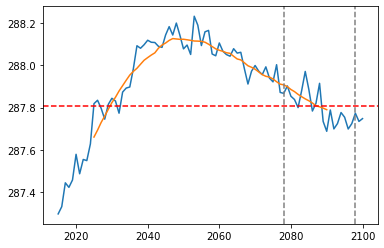

In [25]:
### try 

get_transient_climate_crit_T(mod = 'IPSL-CM6A-LR', var='tas', table='Amon', scen = 'ssp119', crit_warming=2, window_length=21)

  0%|          | 0/4 [00:00<?, ?it/s]

    Year        gmst  gmst_rolling  gmst_roll_diff
19  2034  288.471937    288.464711        0.015923


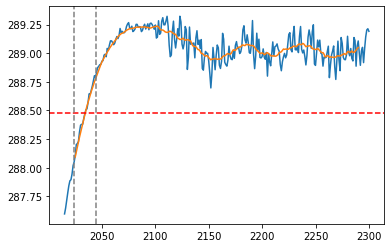


 25%|██▌       | 1/4 [03:20<10:01, 200.37s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
17  2032  288.536209     288.49056        0.009926


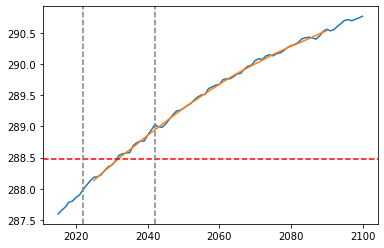


 50%|█████     | 2/4 [06:06<06:00, 180.39s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
17  2032  288.469955    288.495032        0.014397


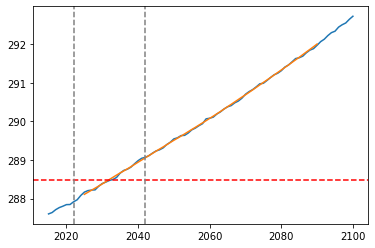


 75%|███████▌  | 3/4 [08:15<02:36, 156.87s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
16  2031  288.516225     288.50556        0.024925


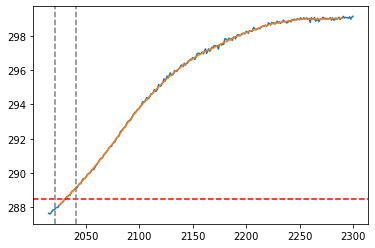


  0%|          | 0/4 [00:00<?, ?it/s]/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


    Year       gmst  gmst_rolling  gmst_roll_diff
27  2042  289.02766    289.058626        0.000512


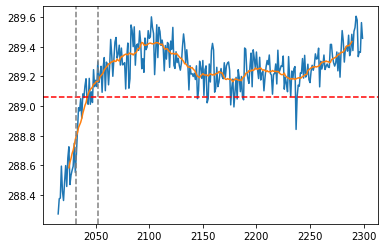

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

 25%|██▌       | 1/4 [01:29<04:28, 89.55s/it]/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


    Year        gmst  gmst_rolling  gmst_roll_diff
28  2043  289.066549    289.059545        0.000407


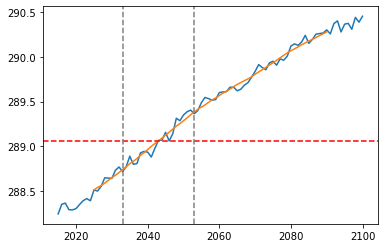

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

 50%|█████     | 2/4 [02:28<02:22, 71.26s/it]/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


    Year        gmst  gmst_rolling  gmst_roll_diff
29  2044  289.046386    289.061635        0.002497


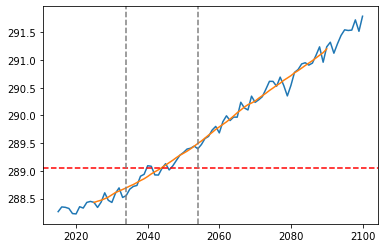

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

 75%|███████▌  | 3/4 [03:00<00:53, 53.42s/it]/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


    Year        gmst  gmst_rolling  gmst_roll_diff
21  2036  289.118527    289.062238          0.0031


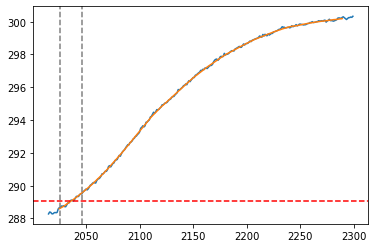

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(

  0%|          | 0/4 [00:00<?, ?it/s]

     Year        gmst  gmst_rolling  gmst_roll_diff
271  2286  287.916475    287.805017        0.000634


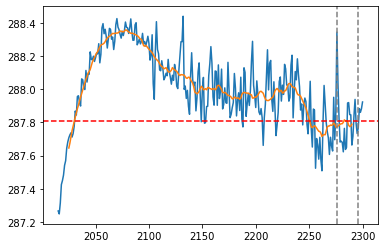


 25%|██▌       | 1/4 [01:01<03:05, 61.93s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
15  2030  287.802954    287.813912        0.008261


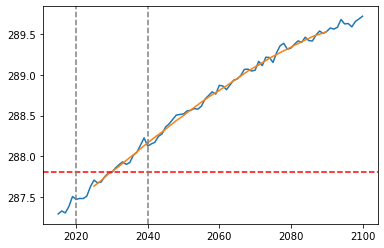


 50%|█████     | 2/4 [01:57<01:56, 58.40s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
14  2029  287.805834    287.792612        0.013039


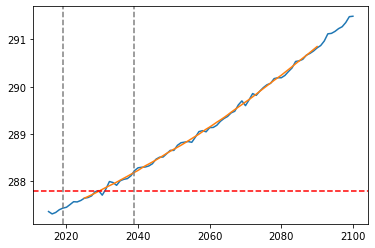


 75%|███████▌  | 3/4 [03:01<01:00, 60.70s/it]

    Year        gmst  gmst_rolling  gmst_roll_diff
13  2028  287.808727    287.803074        0.002576


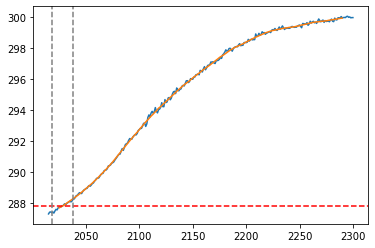


100%|██████████| 3/3 [18:50<00:00, 376.80s/it]


In [20]:
### now run over all
for mod in tqdm(mods):
    for scen in tqdm(SSP_scens):
        get_transient_climate_crit_T(mod = mod, var='tas', 
        table='Amon', scen = scen, crit_warming=2, window_length=21)

### try again, this time taking the transient period at the minimum gradient of the ssp126 run.

In [20]:
def get_max_temp_overshoot_scen(mod, overshoot_scen='ssp126',
                                window_length=21, out_df_name='overshoot_max_temps_df'):
                                    
    """ returns the peak temperature (meaned over a window length) 
        attained in a selected scenario (recommended ssp126 - it 
        needs to be an overshoot scenario for this method to make
        sense) for the given model. 
     """
    var, table = 'tas', 'Amon'
    
    folder_tas_126 = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/tas/*/latest/'.format(
            m=mod, s=overshoot_scen))
    
    ds, n_ens = read_in_ens_mean(folder_tas_126)
    
    ds = ds.sel(time=slice(None, '2150'))
    ds_annual_spatial_mean = calc_spatial_mean(ds.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_annual_spatial_mean.year.values,
                           'gmst': ds_annual_spatial_mean.values})
    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
    print(df[df.gmst_rolling == df.gmst_rolling.max()])


    crossing_df = df[df.gmst_rolling == df.gmst_rolling.max()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
    slope = stats.linregress(df_window['Year'], df_window['gmst']).slope
    
    crossing_df = df[df.gmst_rolling == df.gmst_rolling.max()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    ds_window = ds.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    crit_temp = calc_spatial_mean(ds_window.tas, lon_name="x", lat_name="y").mean(dim="year")
    crit_temp = crit_temp.values + 0
    
    df_path = 'int_outs_ssps/{o}.csv'.format(o=out_df_name)
    try:
        in_df = pd.read_csv(df_path, index_col=[0])
    except: 
        in_df = pd.DataFrame()        
    out_df = pd.DataFrame({'Model':mod,
                           'Overshoot_scenario':overshoot_scen,
                           'Max_temp': crit_temp,
                           'Year_of_max_temp':crossing_year,
                           'Window':window_length,
                           'T_gradient':slope}, index=[0])
    out_df.drop(out_df.filter(regex="Unname"),axis=1, inplace=True)
    out_df = pd.concat([in_df, out_df]).drop_duplicates(subset=['Model', 'Overshoot_scenario']).reset_index(drop=True)
                                    
    out_df.to_csv(df_path)

    # plot for sanity check
    plt.plot(df['Year'], df['gmst'])
    plt.plot(df['Year'], df['gmst_rolling'])
    plt.axhline(crit_temp, c='r', ls='--')
    plt.axvline(window_years[0], c='gray', ls='--')
    plt.axvline(window_years[1], c='gray', ls='--')
    plt.savefig('int_outs_ssps/check_figs/{m}_{o}.jpg'.format(m=mod, o=overshoot_scen))
    plt.show()
    
    
    return crit_temp, out_df
    

In [21]:
def get_window(mod, ensemble_member, scenario,
               window_length=21, out_df_name='windows_df',
               in_df_name = 'overshoot_max_temps_df.csv'):
                                    
    """ finds the window years for a given ensemble member and model
        then calculates that run's output mean and std fields within 
        the window for the chosen variable
     """
    print(mod+ensemble_member+scenario)
    dir_tas = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/{e}/Amon/tas/*/latest/'.format(
            m=mod, s=scenario, e=ensemble_member))
    ds_tas = read_in(dir_tas[0])

    ds_tas_annual_spatial_mean = calc_spatial_mean(ds_tas['tas'], lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_tas_annual_spatial_mean.year.values,
                           'gmst': ds_tas_annual_spatial_mean.values})
    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
                   
    at_df = pd.read_csv('int_outs_ssps/'+in_df_name)
    at_df = at_df[at_df['Model']==mod]
    crit_temp = at_df['Max_temp'].values[0]+0
    overshoot_scen = at_df['Overshoot_scenario'].values[0]
    #print('crit_temp: '+str(crit_temp))

    df['gmst_roll_diff'] = np.abs(df['gmst_rolling'] - crit_temp)
    
    #print(df)
    #print(df[df.gmst_roll_diff == df.gmst_roll_diff.min()])
    crossing_df = df[df.gmst_roll_diff == df.gmst_roll_diff.min()]
    #print(crossing_df)
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    print(window_years)
    df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
    slope = stats.linregress(df_window['Year'], df_window['gmst']).slope
    mean_T = df_window['gmst'].mean()

    df_path = 'int_outs_ssps/{o}.csv'.format(o=out_df_name)
    try:
        in_df = pd.read_csv(df_path, index_col=[0])
    except: 
        in_df = pd.DataFrame()        
    out_df = pd.DataFrame({'Model':mod,
                           'Ensemble_member':ensemble_member,
                           'Scenario':scenario,
                           'Overshoot_scenario':overshoot_scen,
                           'Mean_window_temp': mean_T,
                           'Central_year':crossing_year,
                           'Window_length':window_length,
                           'Window_start':window_years[0],
                           'Window_end':window_years[1],
                           'T_gradient':slope}, index=[0])
    out_df.drop(out_df.filter(regex="Unname"),axis=1, inplace=True)
    out_df = pd.concat([in_df, out_df]).drop_duplicates(subset=['Model',
                        'Ensemble_member','Scenario']).reset_index(drop=True)
    out_df.to_csv(df_path)

    
    # plot for sanity check
    #plt.plot(df['Year'], df['gmst'])
    #plt.plot(df['Year'], df['gmst_rolling'])
    #plt.axhline(crit_temp, c='r', ls='--')
    #plt.axvline(window_years[0], c='gray', ls='--')
    #plt.axvline(window_years[1], c='gray', ls='--')
    #plt.show()
                      
    return window_years
    

### now run

  0%|          | 0/1 [00:00<?, ?it/s]/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


    Year        gmst  gmst_rolling
78  2093  289.251532    289.428478


/tmp/ipykernel_7911/973569393.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]


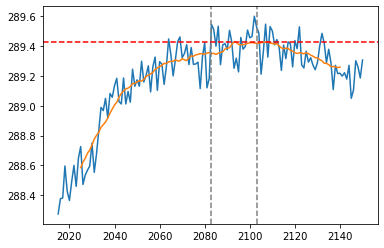

100%|██████████| 1/1 [00:29<00:00, 29.25s/it]


In [45]:
################ (1) 
################ calculate the temperature we will 
################ use to define our window for each model
################
################
################

# takes a couple mins per mod, longer for ukesm (larger ensemble)
mods_to_run = ['IPSL-CM6A-LR', 'CESM2-WACCM', 'UKESM1-0-LL']
mods_to_run2 = ['MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
mods_to_run3 = ['CESM2-WACCM']

for mod in tqdm(mods_to_run):
    crit_temp, df = get_max_temp_overshoot_scen(mod=mod, overshoot_scen='ssp126', 
                                                window_length=21,
                                                out_df_name='overshoot_max_temps_df')
    

In [75]:

################ make a df of mods, scenarios, and ensemble members
mods_to_run = ['IPSL-CM6A-LR', 'CESM2-WACCM', 'UKESM1-0-LL']
mods_to_run2 = ['MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']

SSP_scens = ['ssp126',
             'ssp245',
             'ssp370',
             'ssp585']

DF_runs = pd.DataFrame()
for mod in mods_to_run+mods_to_run2:
    for scen in SSP_scens:
        xs = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/Amon/pr/*/latest/'.format(m=mod, s=scen))
        es = []
        for x in xs:
            e = x.split('/')[9]
            es.append(e)
        df = pd.DataFrame({'Model':mod,
                          'Scenario':scen,
                          'Ensemble_member':es})
        DF_runs = pd.concat([DF_runs, df])


## keep max 5 ens mems to speed up processing
DF_runs = DF_runs.groupby(['Model', 'Scenario']).head(5).reset_index()
DF_runs

,index,Model,Scenario,Ensemble_member
0,0,IPSL-CM6A-LR,ssp126,r1i1p1f1
1,1,IPSL-CM6A-LR,ssp126,r2i1p1f1
2,2,IPSL-CM6A-LR,ssp126,r3i1p1f1
3,3,IPSL-CM6A-LR,ssp126,r4i1p1f1
4,4,IPSL-CM6A-LR,ssp126,r6i1p1f1
...,...,...,...,...
90,0,CNRM-ESM2-1,ssp585,r1i1p1f2
91,1,CNRM-ESM2-1,ssp585,r2i1p1f2
92,2,CNRM-ESM2-1,ssp585,r3i1p1f2
93,3,CNRM-ESM2-1,ssp585,r4i1p1f2


In [89]:
################ (2) 
################ calculate the window years for each mod, scen and ens_mem, 
################ as the period with tas closest to the max tas 
################ in the overshoot scenario
################ 

for i in DF_runs[DF_runs['Model']=='CESM2-WACCM'].index:
    mod = DF_runs['Model'][i]
    scen = DF_runs['Scenario'][i]
    ens = DF_runs['Ensemble_member'][i]
    
    window_years = get_window(mod=mod, ensemble_member=ens, scenario=scen,
                   window_length=21, out_df_name='windows_df',
                   in_df_name = 'overshoot_max_temps_df.csv')

CESM2-WACCMr1i1p1f1ssp126


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2083, 2103]
CESM2-WACCMr1i1p1f1ssp245


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2043, 2063]
CESM2-WACCMr2i1p1f1ssp245


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2046, 2066]
CESM2-WACCMr3i1p1f1ssp245


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2042, 2062]
CESM2-WACCMr1i1p1f1ssp370


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2042, 2062]
CESM2-WACCMr2i1p1f1ssp370


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2035, 2055]
CESM2-WACCMr3i1p1f1ssp370


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2035, 2055]
CESM2-WACCMr1i1p1f1ssp585


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2033, 2053]
CESM2-WACCMr2i1p1f1ssp585


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2032, 2052]
CESM2-WACCMr3i1p1f1ssp585


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[2035, 2055]


/tmp/ipykernel_7911/1635610828.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_window = df[df['Year'] >= window_years[0]][df['Year'] <= window_years[1]]


In [90]:
################ (3) 
################ Calculate and save the output mean state and std maps
################ for each model, scenario and ensemble member
################
################
################

var = 'tas'
windows_df = pd.read_csv('int_outs_ssps/windows_df.csv')

for i in tqdm(DF_runs.index):
    mod = DF_runs['Model'][i]
    scen = DF_runs['Scenario'][i]
    ens = DF_runs['Ensemble_member'][i]

    
    dir = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/{e}/Amon/{v}/*/latest/'.format(
            m=mod, s=scen, e=ens, v=var))
    #try:
    
    if len(dir)==0:
        print(mod, scen, ens, ': empty')
    else:
        files = []
        for x in os.listdir(dir[0]):
            files.append(dir[0] + x)
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    
        ds = ds.groupby("time.year").mean(dim="time")
        
        at_windows_df = windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen][windows_df['Ensemble_member']==ens]
        window_start, window_end = at_windows_df['Window_start'].values[0], at_windows_df['Window_end'].values[0]
        
        #print(window_start, window_end)
    
        ds_window = ds.sel(year=slice(window_start, window_end))
        map_mean = ds_window.mean(dim=['year'])
        map_mean['Ensemble_member'] = ens
    
        out_folders = []
        out_folder = 'int_outs_ssps/{m}_{s}_{v}/'.format(m=mod, s=scen, v=var)
        out_folders.append(out_folder)
        if not os.path.isdir(out_folder):
            os.mkdir(out_folder)
        out_path = '{m}_{s}_{e}_{v}.nc'.format(m=mod, s=scen, e=ens, v=var)
        map_mean.to_netcdf(out_folder+out_path)
    #except:
    #    print(mod, scen, ens)
    #    print(dir)
    #map_std = ds_window.std(dim=['year'])
    

  0%|          | 0/95 [00:00<?, ?it/s]/tmp/ipykernel_7911/1927690904.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  at_windows_df = windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen][windows_df['Ensemble_member']==ens]
  1%|          | 1/95 [00:05<08:04,  5.15s/it]/tmp/ipykernel_7911/1927690904.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  at_windows_df = windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen][windows_df['Ensemble_member']==ens]
  2%|▏         | 2/95 [00:06<04:37,  2.98s/it]/tmp/ipykernel_7911/1927690904.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  at_windows_df = windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen][windows_df['Ensemble_member']==ens]
  3%|▎         | 3/95 [00:07<03:23,  2.21s/it]/tmp/ipykernel_7911/1927690904.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  at_

In [2]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

/tmp/ipykernel_564/1669732380.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_564/1669732380.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_564/1669732380.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_564/1669732380.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


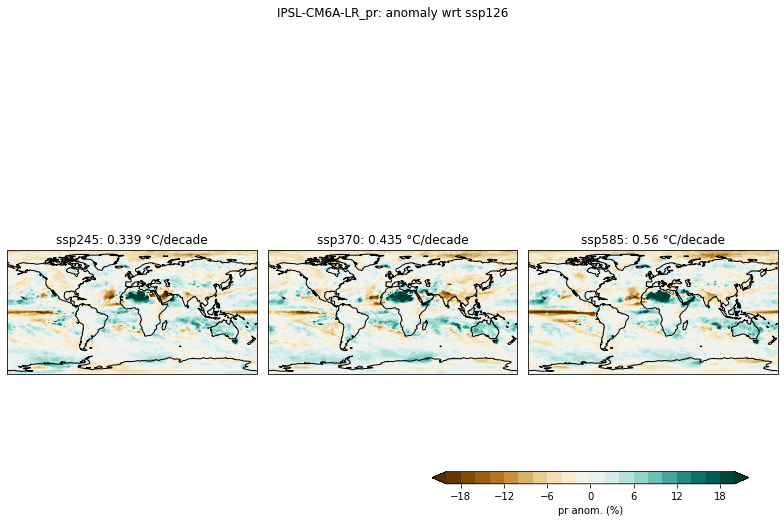

In [29]:
############ PLOTTING
percent = False

scens =     [#'ssp126',
             'ssp245',
             'ssp370',
             'ssp585']

mod = 'IPSL-CM6A-LR'

windows_df = pd.read_csv('int_outs_ssps/windows_df.csv')



baseline_scen = 'ssp126'

var = 'pr'

if percent:
    conversion_units = {'tas':1, 
                         'pr':1}

    units = {'tas':'%', 
             'pr':'%'}
else:
    conversion_units = {'tas':1, 
                        'pr':86400}

    units = {'tas':'°C', 
             'pr':'mm_per_day'}

cmaps = {'tas':'RdBu_r', 
         'pr':'BrBG'}

nrows=1
ncols=len(scens)

# Define the contour levels to use in plt.contourf
if percent:
    clevs=np.arange(-20,22,2)
else:
    if var == 'tas':
        clevs=np.arange(-2.2,2.5,0.4) 
    elif var == 'pr':
        clevs=np.arange(-0.5,0.55,0.05) 
    

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the scnearios
for i,scen in enumerate(scens):
    folder = 'int_outs_ssps/{m}_{s}_{v}/'.format(m=mod, s=scen, v=var)
    ds, n_ens = read_in_ens_mean([folder])

    base_folder = 'int_outs_ssps/{m}_{s}_{v}/'.format(m=mod, s=baseline_scen, v=var)
    base_ds, n_base = read_in_ens_mean([base_folder])

    grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))

    if percent:
        ds = 100*(ds-base_ds)/base_ds
    else:
        ds = ds-base_ds
    data = ds[var].values
    data,lons=add_cyclic_point(data,coord=ds['x'])
    # Contour plot
    cs=axs[i].contourf(lons,ds['y'],data*conversion_units[var],
                           clevs,
                          transform = ccrs.PlateCarree(),
                          cmap=cmaps[var],
                           extend='both')

    # Title each subplot with the name of the model
    axs[i].set_title(scen+': '+grad+' °C/decade')

    # Draw the coastines for each subplot
    axs[i].coastlines()


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.55, 0.2, 0.4, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='{v} anom. ({u})'.format(v=var, u=units[var]))

# Add a big title at the top
plt.suptitle('{m}_{v}: anomaly wrt {b}'.format(m=mod, v=var, b=baseline_scen))
plt.tight_layout()
plt.savefig('Figures/{m}_{v}__anomaly_wrt_{b}_{u}.jpg'.format(m=mod, v=var, b=baseline_scen, u=units[var]), dpi=450)

In [54]:
os.listdir(folder)

['CESM2-WACCM_ssp245_r1i1p1f1_pr.nc',
 'CESM2-WACCM_ssp245_r2i1p1f1_pr.nc',
 'CESM2-WACCM_ssp245_r3i1p1f1_pr.nc',
 '.ipynb_checkpoints']

/tmp/ipykernel_569/3863263092.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_569/3863263092.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_569/3863263092.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_569/3863263092.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
/tmp/ipykernel_569/3863263092.py:67: UserWarning: Boolean Series key will be

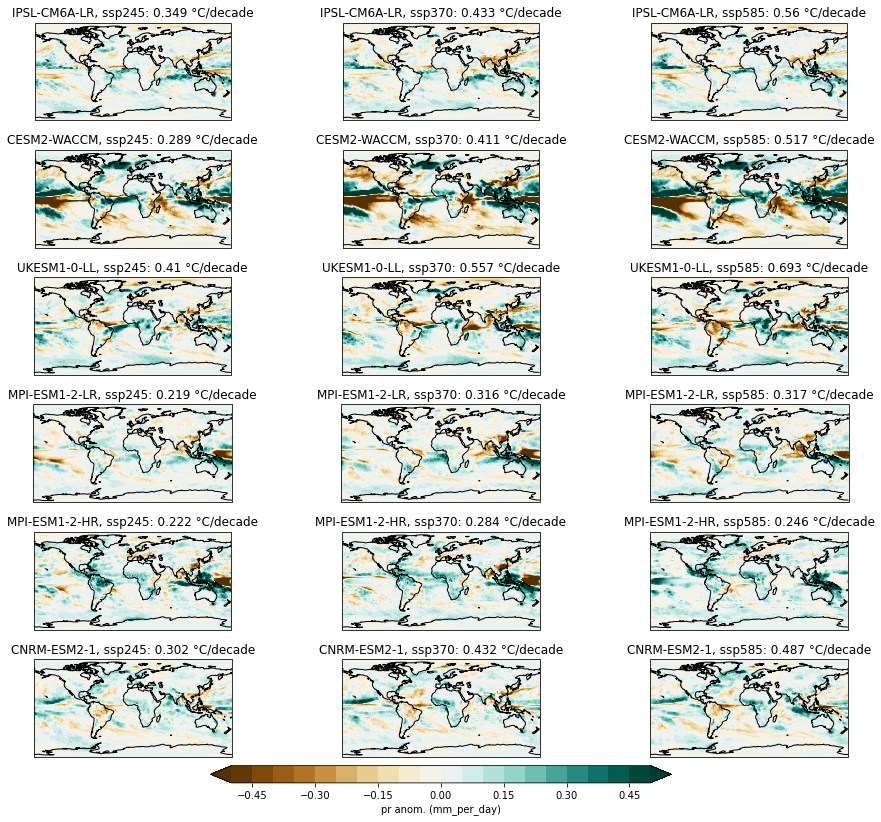

In [3]:
############ PLOTTING
percent = False

scens =     [#'ssp126',
             'ssp245',
             'ssp370',
             'ssp585']

mods_to_run = ['IPSL-CM6A-LR', 'CESM2-WACCM', 'UKESM1-0-LL']
mods_to_run2 = ['MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
mods = mods_to_run + mods_to_run2

windows_df = pd.read_csv('int_outs_ssps/windows_df.csv')



baseline_scen = 'ssp126'

var = 'pr'

if percent:
    conversion_units = {'tas':1, 
                         'pr':1}

    units = {'tas':'%', 
             'pr':'%'}
else:
    conversion_units = {'tas':1, 
                        'pr':86400}

    units = {'tas':'°C', 
             'pr':'mm_per_day'}

cmaps = {'tas':'RdBu_r', 
         'pr':'BrBG'}

nrows=len(mods)
ncols=len(scens)

# Define the contour levels to use in plt.contourf
if percent:
    clevs=np.arange(-20,22,2)
else:
    if var == 'tas':
        clevs=np.arange(-2.2,2.5,0.4) 
    elif var == 'pr':
        clevs=np.arange(-0.5,0.55,0.05) 
    

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,12))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
j=0
for mod in mods:
    #Loop over all of the scnearios
    for i,scen in enumerate(scens):
        ax = axs[j, i]
        folder = 'int_outs_ssps/{m}_{s}_{v}/'.format(m=mod, s=scen, v=var)
        ds, n_ens = read_in_ens_mean([folder])
    
        base_folder = 'int_outs_ssps/{m}_{s}_{v}/'.format(m=mod, s=baseline_scen, v=var)
        base_ds, n_base = read_in_ens_mean([base_folder])
    
        grad = str(np.round(10*windows_df[windows_df['Model']==mod][windows_df['Scenario']==scen]['T_gradient'].mean(), 3))
    
        if percent:
            ds = 100*(ds-base_ds)/base_ds
        else:
            ds = ds-base_ds
        data = ds[var].values
        data,lons=add_cyclic_point(data,coord=ds['x'])
        # Contour plot
        cs=ax.contourf(lons,ds['y'],data*conversion_units[var],
                               clevs,
                              transform = ccrs.PlateCarree(),
                              cmap=cmaps[var],
                               extend='both')
    
        # Title each subplot with the name of the model
        ax.set_title(mod+', '+scen+': '+grad+' °C/decade')
    
        # Draw the coastines for each subplot
        ax.coastlines()
    j=j+1

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.9,
                    wspace=0.01, hspace=0.3)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.3, 0.07, 0.4, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='{v} anom. ({u})'.format(v=var, u=units[var]))

# Add a big title at the top
#plt.suptitle('{m}_{v}: anomaly wrt {b}'.format(m=mod, v=var, b=baseline_scen))
#plt.tight_layout()
plt.savefig('Figures/Main_{v}__anomaly_wrt_{b}_{u}.jpg'.format(m=mod, v=var, b=baseline_scen, u=units[var]), dpi=450)

In [21]:

def get_transient_climate_flat126(mod, scen, window_length=21):
    """ produce a spatial nc file, with map of mean values during window 
    window here is defined as the period when a given scenario has the same
    temp as that model's ssp126 scenario does, when it hits it's peak (and thus
    has minimum gradient). 
     """

    var, table = 'tas', 'Amon'
    
    folder_tas_126 = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/ssp126/*/Amon/tas/*/latest/'.format(
            m=mod))
    
    folder_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
            m=mod, s=scen, t=table, v=var))
    
    
    ds, n_ens = read_in_ens_mean(folder_tas_126)
    
    ds = ds.sel(time=slice(None, '2150'))
    ds_annual_spatial_mean = calc_spatial_mean(ds.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_annual_spatial_mean.year.values,
                           'gmst': ds_annual_spatial_mean.values})
    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
    #df['gmst_roll_gradient'] = np.gradient(df['gmst_rolling'])
    print(df[df.gmst_rolling == df.gmst_rolling.max()])
    
    crossing_df = df[df.gmst_rolling == df.gmst_rolling.max()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    ds_window = ds.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    crit_temp = calc_spatial_mean(ds_window.tas, lon_name="x", lat_name="y").mean(dim="year")
    crit_temp = crit_temp.values + 0
    
    plt.plot(df['Year'], df['gmst'])
    plt.plot(df['Year'], df['gmst_rolling'])
    plt.axhline(crit_temp, c='r', ls='--')
    plt.axvline(window_years[0], c='gray', ls='--')
    plt.axvline(window_years[1], c='gray', ls='--')
    plt.show()
    
    #now calc output for window and save
    ds_var, n_ens_var = read_in_ens_mean(folder_var)

    ds_var_annual_spatial_mean = calc_spatial_mean(ds_var[var], lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
    df = pd.DataFrame({'Year': ds_var_annual_spatial_mean.year.values,
                           'gmst': ds_var_annual_spatial_mean.values})
    df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
    df['gmst_roll_diff'] = np.abs(df['gmst_rolling'] - crit_temp)
    print(df[df.gmst_roll_diff == df.gmst_roll_diff.min()])
    crossing_df = df[df.gmst_roll_diff == df.gmst_roll_diff.min()]
    crossing_year = crossing_df['Year'].values[0]
    window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
    #print(window_years)

    ds_window = ds_var.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    map_mean = ds_window.mean(dim=['year'])
    map_mean['Gradient']=grad
    map_std = ds_window.std(dim=['year'])

    out_dir_mean = 'int_outs_ssps/{s}_{v}_flatssp126_map_means'.format(s=scen, v=var)
    out_dir_std = 'int_outs_ssps/{s}_{v}_flatssp126_map_stds'.format(s=scen, v=var)
    for dir in [out_dir_mean, out_dir_std]:
        if not os.path.isdir(dir):
            os.mkdir(dir)
    
    map_mean.to_netcdf(out_dir_mean + '/{m}.nc'.format(m=mod))
    map_std.to_netcdf(out_dir_std + '/{m}.nc'.format(m=mod))
    return 

    Year        gmst  gmst_rolling
63  2078  288.403917    288.356528


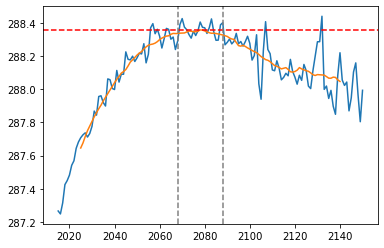

In [6]:
# test
mod='IPSL-CM6A-LR'
scen='ssp245'
window_length=21
var, table = 'tas', 'Amon' #not yet implemented for pr
    
folder_tas_126 = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/ssp126/*/Amon/tas/*/latest/'.format(
        m=mod))

folder_var = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
        m=mod, s=scen, t=table, v=var))


ds, n_ens = read_in_ens_mean(folder_tas_126)

ds = ds.sel(time=slice(None, '2150'))
ds_annual_spatial_mean = calc_spatial_mean(ds.tas, lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
df = pd.DataFrame({'Year': ds_annual_spatial_mean.year.values,
                       'gmst': ds_annual_spatial_mean.values})
df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
#df['gmst_roll_gradient'] = np.gradient(df['gmst_rolling'])
print(df[df.gmst_rolling == df.gmst_rolling.max()])

crossing_df = df[df.gmst_rolling == df.gmst_rolling.max()]
crossing_year = crossing_df['Year'].values[0]
window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
ds_window = ds.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
crit_temp = calc_spatial_mean(ds_window.tas, lon_name="x", lat_name="y").mean(dim="year")


plt.plot(df['Year'], df['gmst'])
plt.plot(df['Year'], df['gmst_rolling'])
plt.axhline(crit_temp, c='r', ls='--')
plt.axvline(window_years[0], c='gray', ls='--')
plt.axvline(window_years[1], c='gray', ls='--')
plt.show()


In [23]:
#now calc output for window and save
ds_var, n_ens_var = read_in_ens_mean(folder_var)

ds_var_annual_spatial_mean = calc_spatial_mean(ds_var[var], lon_name="x", lat_name="y").groupby("time.year").mean(dim="time")
df = pd.DataFrame({'Year': ds_var_annual_spatial_mean.year.values,
                       'gmst': ds_var_annual_spatial_mean.values})
df['gmst_rolling'] = df['gmst'].rolling(window=window_length, center=True).mean()
df['gmst_roll_diff'] = np.abs(df['gmst_rolling'] - crit_temp)
print(df[df.gmst_roll_diff == df.gmst_roll_diff.min()])
crossing_df = df[df.gmst_roll_diff == df.gmst_roll_diff.min()]
crossing_year = crossing_df['Year'].values[0]
window_years = [int(crossing_year-(window_length-1)/2), int(crossing_year+(window_length-1)/2)]
#print(window_years)

ds_window = ds_var.groupby("time.year").mean(dim="time").sel(year=slice(window_years[0], window_years[1]))
    

    Year        gmst  gmst_rolling  gmst_roll_diff
31  2046  288.399029    288.370087         0.01356
